In [45]:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
df = pd.read_csv('cleaned_cali_2022.csv', sep=';')
print(df.columns)

Index(['county_name', 'loan_type_name', 'loan_purpose_name', 'loan_amount',
       'loan_to_value_ratio', 'interest_rate', 'action_name',
       'preapproval_name', 'property_value', 'total_units', 'occupancy_name',
       'construction_name', 'income', 'debt_to_income_midpoint',
       'credit_score_name', 'applicant_age_midpoint', 'applicant_sex_name',
       'applicant_race_1_name', 'applicant_ethnicity_1', 'tract_population',
       'tract_minority_population_percent',
       'ffiec_msa_md_median_family_income', 'tract_to_msa_income_percentage',
       'tract_owner_occupied_units', 'tract_one_to_four_family_homes',
       'tract_median_age_of_housing_units'],
      dtype='object')


In [47]:
x = df[["loan_amount", "property_value", "income", "debt_to_income_midpoint",
        "applicant_age_midpoint", "applicant_sex_name", "applicant_race_1_name"]]

y = df["action_name"].apply(lambda x: 1 if x == "Loan originated" else 0)

In [48]:
x = x.fillna(x.mean)

In [49]:
for col in x.select_dtypes(include='number'):
    x.fillna({col: x[col].median()}, inplace=True)

for col in x.select_dtypes(include='object'):
    x.fillna({col: x[col].mode()[0]}, inplace=True)

In [50]:
label_encoders = {}
for col in x.select_dtypes(include='object'):
    x[col] = x[col].astype(str)
    le = LabelEncoder()
    x[col] = le.fit_transform(x[col])

In [51]:
target_le = LabelEncoder()
y = target_le.fit_transform(y)

In [52]:
scaler = StandardScaler()
num_cols = x.select_dtypes(include='number').columns
x[num_cols] = scaler.fit_transform(x[num_cols])

In [53]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
model = RandomForestClassifier(n_estimators = 100, random_state = 42)
model.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [54]:
y_pred = model.predict(x_test)

In [55]:
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy:  0.875802752293578
Confusion Matrix:
[[58927 14524]
 [ 6053 86176]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.80      0.85     73451
           1       0.86      0.93      0.89     92229

    accuracy                           0.88    165680
   macro avg       0.88      0.87      0.87    165680
weighted avg       0.88      0.88      0.87    165680



In [56]:
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'feature': x.columns, 'importance': importances}).sort_values(by='importance', ascending=False)

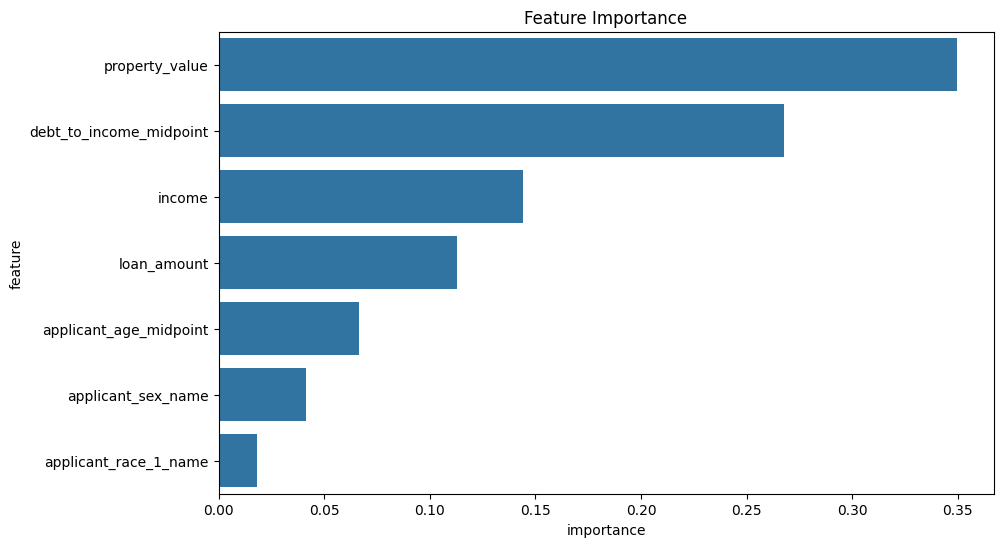

In [57]:
plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title("Feature Importance")
plt.show()

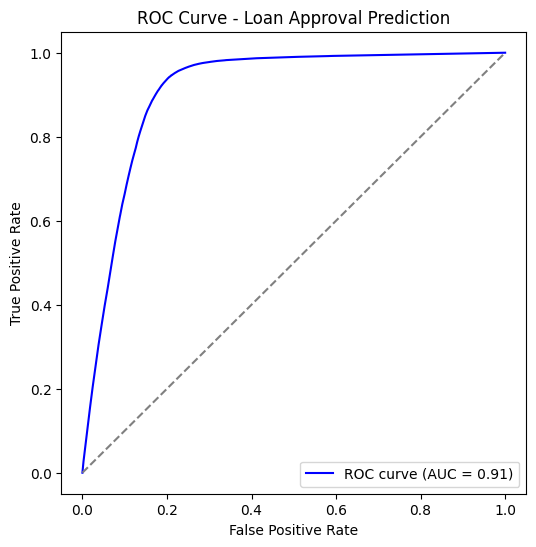

In [58]:
y_prob = model.predict_proba(x_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Loan Approval Prediction")
plt.legend(loc="lower right")
plt.show()

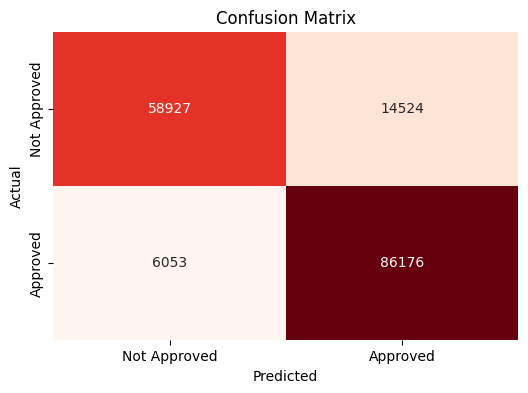

In [59]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", cbar=False,
            xticklabels=['Not Approved', 'Approved'],
            yticklabels=['Not Approved', 'Approved'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()